# `006` Pytorch

Requirements: 005 Multilayer Perceptron.

This notebook shows an example of a simple neural network training using pytorch for a simplified syntax. We will be training on the MNIST dataset, which is a dataset of grayscale images of handwritten digits.

In [1]:
import torchvision

# calling a dataset with download=True downloads it to a local 'data' folder if it doesn't exist already
train = torchvision.datasets.MNIST(root='data', download=True)
# the test set is a separate dataset
test = torchvision.datasets.MNIST(root='data', download=True, train=False)

train.data.shape, test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

The input is a set of 60k images of 28x28 pixels, and the output is a set of 60k labels, each one corresponding to a digit from 0 to 9.

tensor([5, 0, 4, 1])

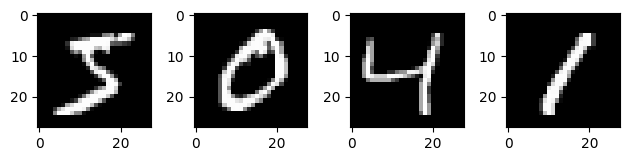

In [2]:
import matplotlib.pyplot as plt

for i in range(4):
	plt.subplot(1, 4, i + 1)
	plt.imshow(train.data[i], cmap='gray')
plt.tight_layout()
train.targets[:4]

To use a simple neural network, we will flatten the input images into a vector of $28 \times 28 = 784$ elements, and we will one-hot encode the labels.

One-hot encoding is a way to represent categorical data, where each category is represented by a vector of zeros, except for the index of the category, which is represented by a 1. For example, the digit 3 is represented by the vector `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

In [3]:
import torch

# flatten the images into (N, 784) tensors (-1) means "infer the size"
x = train.data.view(-1, 28 * 28).float()  # .float() converts the uint8 tensor to a float tensor
xt = test.data.view(-1, 28 * 28).float()
y = torch.nn.functional.one_hot(train.targets).float()
yt = torch.nn.functional.one_hot(test.targets).float()
print(f'Some X elements of the first example: {x[0, 200:210]}')
print(f'The first Y: {y[0]}')

Some X elements of the first example: tensor([  0.,   0.,   0.,  49., 238., 253., 253., 253., 253., 253.])
The first Y: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


Now, the linear layers previously defined by creating a weight matrix and a bias vector can be replaced by a `torch.nn.Linear` layer, which does the same thing. The activation functions can be replaced by `torch.nn` functions. This way defines layers and activation functions as objects, and using Sequential let's us define the model so that `model(x)` will make the forward pass through the model and return the output.

In [4]:
model = [torch.nn.Linear(28 * 28, 128), torch.nn.ReLU()]
for _ in range(3):
	model.extend([torch.nn.Linear(128, 128), torch.nn.ReLU()])
model.append(torch.nn.Linear(128, 10))
model = torch.nn.Sequential(*model)
model(x[0])

tensor([-1.2119, -2.4643,  1.4558, -2.1872, -1.2147,  1.4153, -0.4214, -0.9538,
         2.0001, -2.2589], grad_fn=<ViewBackward0>)

The training loop can also be simplified. We can use the `torch.optim` module to define an optimizer. The optimizer will update the weights of the model, and the loss function will calculate the error between the predicted output and the true output.

Additionally, we will compute the loss over multiple examples at once, which is called a **batch**. This is done to speed up the training process, as the gradients are more accurate when computed over multiple examples. However, this introduces a new hyperparameter, the batch size, which is the number of examples in each batch.

Iteration 0, loss: 2.642336130142212
Iteration 200, loss: 0.2802586853504181
Iteration 400, loss: 0.14501002430915833
Iteration 600, loss: 0.21649427711963654
Iteration 800, loss: 0.09373108297586441
Accuracy on the test set: 95.31%


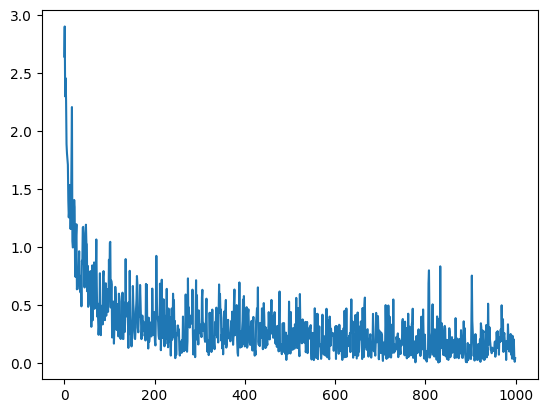

In [5]:
def train(iterations=1000, batch_size=32, learning_rate=0.01):
	optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # SGD is Stochastic Gradient Descent, what we've been doing so far
	losses = []
	for i in range(iterations):
		# sample a random batch of examples
		ix = torch.randint(0, x.shape[0], (batch_size,))
		xb, yb = x[ix], y[ix]
		# calculate the loss
		logits = model(xb)
		loss = torch.nn.functional.cross_entropy(logits, yb.argmax(dim=1))
		# calculate the gradients
		optimizer.zero_grad()
		loss.backward()
		# update the weights
		optimizer.step()
		# stats
		losses.append(loss.item())
		if i % 200 == 0:
			print(f'Iteration {i}, loss: {loss.item()}')
	plt.plot(losses)
	accuracy = (model(xt).argmax(dim=1) == yt.argmax(dim=1)).float().mean().item()
	print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

train()

And just like that, with a nice dataset and a few lines of code, we have trained a simple network capable of recognizing handwritten digits.

We have use a loss function called `cross_entropy`, which is a common loss function for classification problems. It calculates the error between the predicted output and the true output, and it is defined as $-\sum_{i=1}^{n} y_i \log(\hat{y}_i)$, where $y_i$ is the true output and $\hat{y}_i$ is the predicted output.

When adjusting the newly introduced batch size hyperparameter, the best value possible is using the entire dataset at once. However, this is not very efficient and a correct gradient direction can be computed using a smaller batch size. The batch size is a trade-off between efficiency and accuracy. Typically, batch sizes are some small power of 2, like 32, 64, 128, 256, etc. It is typically adjusted through trial and error.

### Layer creation

It is also possible to define custom layers in Pytorch. For this, we just need to define a class that inherits from `torch.nn.Module` and implements the `forward` method. This method should define how the layer processes the input to produce the output. Let's use a custom layer that adds groups of 2 pixels together.

Iteration 0, loss: 3.9799020290374756
Iteration 200, loss: 1.4954333305358887
Iteration 400, loss: 1.7279539108276367
Iteration 600, loss: 1.5466629266738892
Iteration 800, loss: 1.2268388271331787
Accuracy on the test set: 60.15%


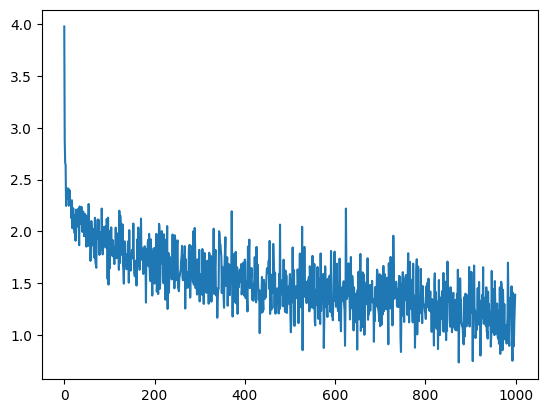

In [23]:
class AddEachTwoPair(torch.nn.Module):
	def __init__(self, size):
		super().__init__()
		self.size = size
		self.weights = torch.nn.Parameter(torch.randn(size))
	
	def forward(self, x):
		x = x * self.weights
		x = x.view(-1, 2, self.size // 2).sum(dim=-2)
		return x.relu()
	
model = [AddEachTwoPair(784), AddEachTwoPair(392), AddEachTwoPair(196), AddEachTwoPair(98)]
for _ in range(3):
	model.extend([torch.nn.Linear(49, 49), torch.nn.ReLU()])
model.append(torch.nn.Linear(49, 10))
model = torch.nn.Sequential(*model)
train()

This new layer is not very useful, but it is a good example of how to define custom layers in Pytorch.